In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# # Input data files are available in the "../input/" directory.
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
        
import pandas as pd
import numpy as np
import cv2
import os
from datetime import date
import matplotlib.pyplot as plt

#For CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout, ZeroPadding3D
from tensorflow.keras.layers import Conv2D, MaxPooling3D,MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import  ReduceLROnPlateau

#

# Any results you write to the current directory are saved as output.


In [13]:
# import git
# git.Git(os.getcwd()).clone("https://github.com/qubvel/efficientnet.git")
import efficientnet.tfkeras as efn

In [14]:
import os
path_to_traindir = '/kaggle/input/hackerearth-garden-nerd-challenge/he_challenge_data/data/train/'
path_to_testdir = '/kaggle/input/hackerearth-garden-nerd-challenge/he_challenge_data/data/test/'
path_train_csv = '/kaggle/input/hackerearth-garden-nerd-challenge/he_challenge_data/data/train.csv'
path_test_csv = '/kaggle/input/hackerearth-garden-nerd-challenge/he_challenge_data/data/test.csv'

train_df = pd.read_csv(path_train_csv)
test_df = pd.read_csv(path_test_csv)
# os.listdir(path_to_dir)

18540
perClass_nb_of_imgs: 51    582
77    567
46    441
73    438
89    414
     ... 
21     90
7      90
1      90
27     90
45     90
Name: category, Length: 102, dtype: int64


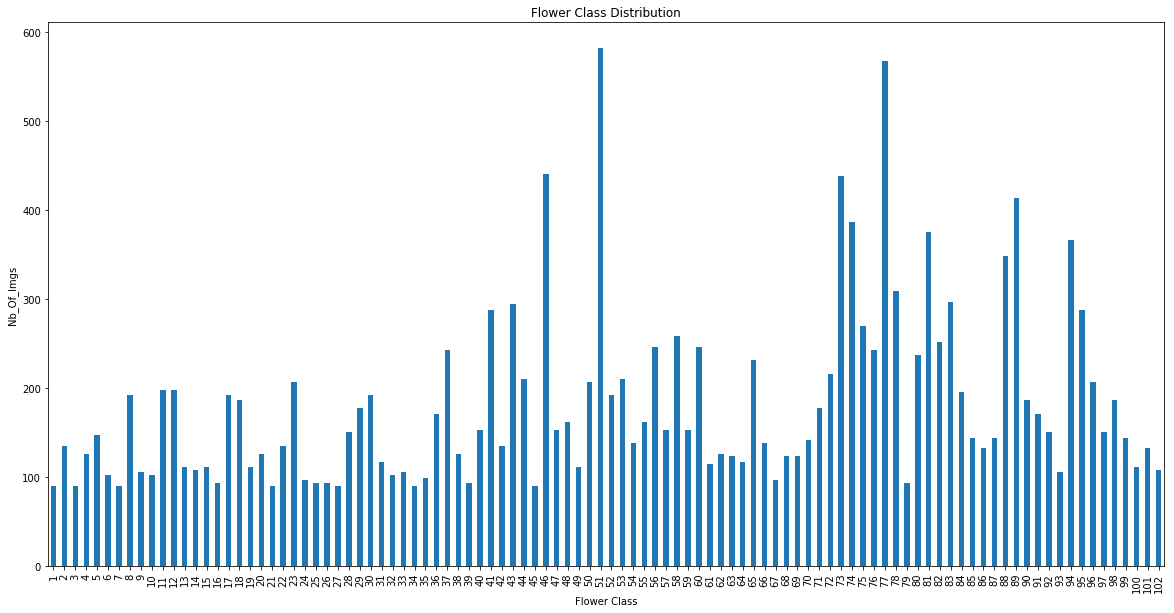

In [15]:
#===============================================================================
# EDA: Lets find out more about dataset
#===============================================================================

print(len(os.listdir(path_to_traindir)))
# print(train_df.head())
# print(test_df.head())

# get no of images per category
flowerClasses = train_df.category.unique()
print("perClass_nb_of_imgs:", train_df.category.value_counts())

# Disply no of images per category
train_df.category.value_counts().sort_index().plot(kind="bar",figsize=(20,10),rot=0)
plt.title("Flower Class Distribution")
plt.xticks(rotation='vertical')
plt.xlabel("Flower Class")
plt.ylabel("Nb_Of_Imgs")
plt.savefig('EDA_class_distribution.png')

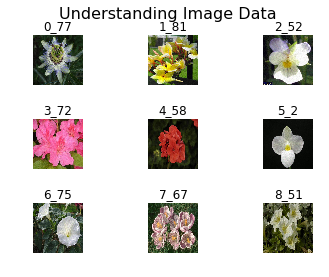

In [16]:
train_df.image_id = train_df.image_id.astype(str)

#Add Img_path Column to access images in Dataframe
train_df['img_path'] = path_to_traindir + '/' + train_df.image_id[:] + '.jpg'



# Add Routin To display sample data
def displayImageData(in_df,no_of_sample=9):
    """Disaplay Sample Image data
    
    Arguments:
        in_df {pandas dataframe} -- Input train Dataframe with Img_Path Column
    
    Keyword Arguments:
        no_of_sample {int} -- Number of Image samples to display (default: {9})
    """
    fig = plt.figure("EDA Image Data")
    fig.subplots_adjust(hspace=0.7, wspace=0.1)
    fig.suptitle('Understanding Image Data', fontsize=16)

    for n, path in enumerate(in_df.img_path[:no_of_sample]):
        label = str(in_df.category[n])
        ImgTitle = in_df.image_id[n] +'_'+label
        Img = cv2.imread(path)
        #Note: Adjust the subplot grid so nb_of_images fits pefect ina grid.
        ax = fig.add_subplot(3,3,(n+1))
        plt.imshow(cv2.cvtColor(Img, cv2.COLOR_BGR2RGB))
        ax.set_title(ImgTitle)
        plt.axis('off')
    plt.show()
    return


displayImageData(train_df)

In [17]:
# IMG_SIZE = 456 # Cause EfficientNetB5 - (456, 456, 3)
# BATCH_SIZE = 4
# train_datagen = ImageDataGenerator(rotation_range=360,
#                                    horizontal_flip=True,
#                                    vertical_flip=True,
#                                    validation_split=0.15,                                 
#                                    rescale=1 / 255.)

# train_generator = train_datagen.flow_from_dataframe(train_df, 
#                                                     x_col='img_path', 
#                                                     y_col='category',
#                                                     directory = None,
#                                                     target_size=(IMG_SIZE, IMG_SIZE),
#                                                     batch_size=BATCH_SIZE,
#                                                     class_mode='other', 
#                                                     subset='training')

# val_generator = train_datagen.flow_from_dataframe(train_df, 
#                                                   x_col='img_path', 
#                                                   y_col='category',
#                                                   directory = None,
#                                                   target_size=(IMG_SIZE, IMG_SIZE),
#                                                   batch_size=BATCH_SIZE,
#                                                   class_mode='other',
#                                                   subset='validation')

# path_to_efnB5_weights = '../input/efficientnet-keras-weights-b0b5/efficientnet-b5_imagenet_1000_notop.h5'
# conv_model = efn.EfficientNetB5(weights=None,
#                                 include_top=False,
#                                 input_shape=(IMG_SIZE, IMG_SIZE, 3))
# conv_model.load_weights(path_to_efnB5_weights)
# for layer in conv_model.layers:
#     layer.trainable = False
# model = Sequential()
# model.add(conv_model)
# model.add(GlobalAveragePooling2D())
# model.add(Dropout(0.5))
# model.add(Dense(5, activation="relu"))
# model.add(Dense(1, activation="linear"))

# model.compile(loss='mse',
#               optimizer=Adam(lr=0.00005), 
#               metrics=['mse', 'acc'])
# print(model.summary())

In [22]:
train_df.category = train_df.category.astype(str)
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

IMG_SIZE = 224 
BATCH_SIZE = 8
nb_of_classes = len(train_df.category.unique())
train_datagen = ImageDataGenerator(rotation_range=360,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split=0.15,                                 
                                   rescale=1 / 255.)

train_generator = train_datagen.flow_from_dataframe(train_df, 
                                                    x_col='img_path', 
                                                    y_col='category',
                                                    directory = None,
                                                    target_size=(IMG_SIZE, IMG_SIZE),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical', 
                                                    subset='training')

val_generator = train_datagen.flow_from_dataframe(train_df, 
                                                  x_col='img_path', 
                                                  y_col='category',
                                                  directory = None,
                                                  target_size=(IMG_SIZE, IMG_SIZE),
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical',
                                                  subset='validation')
conv_base = MobileNetV2(weights='imagenet',
                        include_top=False,
                        pooling='avg')
conv_base.trainable = False #Freeze Model 

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))  
model.add(Dense(nb_of_classes,activation='softmax'))

optimizer = Adam(lr=1e-5, decay=1e-6)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])               
model.summary()

Found 15759 validated image filenames belonging to 102 classes.
Found 2781 validated image filenames belonging to 102 classes.


/opt/conda/lib/python3.6/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 1280)              2257984   
_________________________________________________________________
flatten_2 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               655872    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 102)               52326     
Total params: 2,966,182
Trainable params: 708,198
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
# Callbacks
rlr = ReduceLROnPlateau(monitor='val_loss', 
                        factor=0.5, 
                        patience=4, 
                        verbose=1, 
                        mode='auto')


# Begin training
history = model.fit_generator(train_generator,
                    epochs=60,
                    validation_data=val_generator)

import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Epoch 1/60
1779/1970 [==========================>...] - ETA: 1:40 - loss: 2.2654 - acc: 0.4584

In [ ]:
def get_preds_and_labels(model, generator):
    """
    Get predictions and labels from the generator
    """
    preds = []
    labels = []
    for _ in range(int(np.ceil(generator.samples / BATCH_SIZE))):
        x, y = next(generator)
        preds.append(model.predict(x))
        labels.append(y)
    # Flatten list of numpy arrays
    return np.concatenate(preds).ravel(), np.concatenate(labels).ravel()